In [1]:
# imports and laodings
import sys
sys.path.insert(0, '../functions')
import parameter_optimization as po
import pandas as pd
import pickle
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# settings
central_gene = 'b1101'
basal_conditions = ['control__wt_glc__1', 'control__wt_glc__2'] #'crp__delar1ar2_glyc__2'

A_df = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0)
iM_table = pd.read_csv('../data/precise_1.0/iM_table.csv', index_col = 0)
A_df = A_df.rename(index = {index : row['name'] for index, row in iM_table.iterrows()})

M_df = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0)
M_df = M_df.rename(columns = {str(index) : row['name'] for index, row in iM_table.iterrows()})

log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
A_df = A_df[log_tpm_df.columns]

# loading in
df_name = central_gene+'_zerodTrue_mRNA_ratios_and_MA_vals.csv'
ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
ratios_df = ratios_df.sort_values(by = 'actual_mRNA_ratio')
ratio_values = np.linspace(min(ratios_df['actual_mRNA_ratio']), max(ratios_df['actual_mRNA_ratio']), 1000)
f_name = central_gene+'_zerodTrue_cAct_cInh_vals.csv'
cActInh_df = pd.read_csv('../data/save_for_GAMs/'+f_name, index_col = 0)

# save of TF concentrations of baseline values
# for now, it's just always crp
# goofy, scaling to same range/units as are used in GAMs
scaled_df = pd.read_csv('../data/save_for_GAMs/exported_TF_conc.csv', index_col = 0)

# defining constants
#RNAP = 1*10**(-8)
RNAP = 1*10**(-7)
kEscape = 1
TF = 0
#u = 1/3600
#kDeg = 0.00231049
#promoterConc = 1*10**(-9)
#promoterConcVal = 10**(-9)
#cell_volume = 10**(-15) # in liters

# getting grid values
pickle_in = open('../data/pickle_dicts/center_cond_to_gene_to_grid_values.pkl', 'rb')
center_cond_to_gene_to_grid_values = pickle.load(pickle_in)
pickle_in.close()
grid_vals = center_cond_to_gene_to_grid_values[basal_conditions[0]]['b1101']
grid_use = -3
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])
KdRNAPCrp = 2.5118864315095796e-07*1.4

# hard set this in a different way for more normal testing
zz =  {'KdRNAP': 1e-05,
 'KdRNAPCrp': 1.0133501345444593e-06,
 'RNAP': 1e-06,
 'mRNA_total': 1800,
 'cell_volume': 1e-15,
 'k_d_TF': 1,
 'kDeg': 0.0023104906018664843,
 'promoterConcVal': 1e-09,
 'TF': 0,
 'u': 0.0002777777777777778,
 'kEscape': 10.0,
 'KeqOpening': 0.007405754285911965}
RNAP = zz['RNAP']
KdRNAP = zz['KdRNAP']
kEscape = zz['kEscape']
KeqOpening = zz['KeqOpening']



print(KdRNAP)
#print(kEscape)
print(KeqOpening)

if True:
    def mRNA_to_cActivator(mRNA, RNAP = RNAP, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, KeqOpening = KeqOpening): # this appears to be properly working!
        cActivator = (KdRNAPCrp*(KdRNAP + RNAP + KeqOpening*RNAP)*(-1 + \
                mRNA))/(KdRNAP*(KdRNAP + RNAP + KeqOpening*RNAP - \
                KdRNAPCrp*mRNA - RNAP*mRNA - KeqOpening*RNAP*mRNA))

        return(cActivator)

    def mRNA_to_cInhibitor(mRNA, RNAP = RNAP, KdRNAP = KdRNAP, KeqOpening = KeqOpening): # I think the mathematica code might have an error, I'm sticking with this
        cInhibitor = -(((KdRNAP + RNAP + KeqOpening*RNAP)*(-1 + mRNA))/(KdRNAP*mRNA))

        return(cInhibitor)


    def cActivator_cInhibitor_to_mRNA(cActivator, cInhibitor, RNAP = RNAP, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, KeqOpening = KeqOpening):
        mRNA = ((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
                KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
                cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
                KeqOpening)*RNAP)

        return(mRNA)

    def log_tpm_to_mRNA_conc(val):
        mRNA = (2**val)*(10**-6)*1800/cell_volume/(6.022*(10**23))
        return(mRNA)

1e-05
0.007405754285911965


# optimize KdRNAPCrp

Optimal KdRNAPCrp = 4.73e-06, score = -498.00


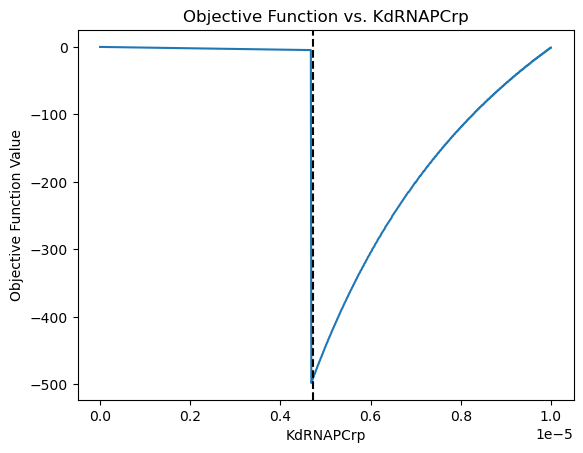

In [2]:
# first let's find the maximum KdRNAPCrp value for the mRNA values
# (the one that does not require negative cActivators at high mRNA ratios)

'''
as KdRNAPCrp gets lower, the inflection point moves right

I want the KdRNAPCrp value that gives me the right-most inflection point
'''

# using ratios_df is not good sampling, moving to a set spacing
ratio_values = np.linspace(min(ratios_df['actual_mRNA_ratio']), max(ratios_df['actual_mRNA_ratio']), 1000)
one_index = min(range(len(ratio_values)), key=lambda i: abs(ratio_values[i] - 1))
def objective_function1(KdRNAPCrp_temp):
    cActs = mRNA_to_cActivator(ratio_values, KdRNAPCrp = KdRNAPCrp_temp)
    
    # Set up penalty
    penalty = 0
    
    # I want to find the sample with the latest point above mRNA ratio 1 that has a negative cActivator value
    # i.e. I'm trying to figure out the highest KdRNAPCrp value I can use that doesn't require negatives
    
    # let's search for the first index that has negative values
    ind = one_index + 1
    found = False
    while ind < len(cActs):
        if cActs[ind] < 0:
            # I've found it, I want to penalize it being very early, so I'll subtract how far along it is
            penalty -= (ind - one_index)
            found = True
            break
        ind += 1
    if not found: # to slope the left part towards the minimum
        penalty -= 1000000*KdRNAPCrp_temp
    else:
        pass#penalty += KdRNAPCrp_temp
    return(penalty)

# setup and minimize
initial_guess = KdRNAP / 4
bounds = [(1e-9, KdRNAP/.99)]
result1 = minimize(objective_function1, initial_guess, bounds = bounds, tol = 1e-10)
max_KdRNAPCrp = result1.x[0] 
print("Optimal KdRNAPCrp = {:.2e}".format(max_KdRNAPCrp), end = ', score = ')
print('{:.2f}'.format(result1.fun))

# plot
# Define the range of KdRNAPCrp values for plotting
KdRNAPCrp_values = np.linspace(1e-9, KdRNAP, 1000)  # Adjust the range as needed

# Calculate the objective function values for each KdRNAPCrp value
objective_values = [objective_function1(KdRNAPCrp) for KdRNAPCrp in KdRNAPCrp_values]

# Create a plot to visualize the objective function
plt.plot(KdRNAPCrp_values, objective_values)
plt.axvline(x = max_KdRNAPCrp, c = 'k', ls = '--')
#plt.ylim(min(objective_values), 10)
plt.xlabel('KdRNAPCrp')
plt.ylabel('Objective Function Value')
plt.title('Objective Function vs. KdRNAPCrp')
plt.show()

Optimal KdRNAPCrp = 4.44e-06, score = -1.69


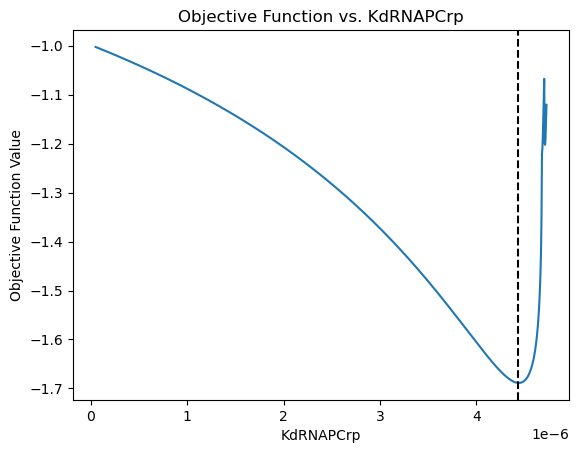

In [3]:
# now with our new maximum, let's look for the ideal value (and we can ignore negative value penalty I think)
# Define your objective function
max_index = min(range(len(ratio_values)), key=lambda i: abs(ratio_values[i] - max(ratio_values)))
closest_index = min(range(len(ratio_values)), key=lambda i: abs(ratio_values[i] - .70*max(ratio_values)))
def objective_function2(KdRNAPCrp_temp):
    cActs = mRNA_to_cActivator(ratio_values, KdRNAPCrp = KdRNAPCrp_temp)
    
    # Set up penalty
    penalty = 0
    
    # let's try to maximize the 80% value
    penalty -= cActs[closest_index]
    
    # I want to maximize "spread" and getting a more diverse range of values... let me think on what that measure would be
    penalty -= np.corrcoef(cActs, np.arange(len(cActs)))[0, 1]
    penalty -= cActs[closest_index]
    
    return(penalty)

# setup and minimize
initial_guess = max_KdRNAPCrp / 2
bounds = [(max_KdRNAPCrp / 100, max_KdRNAPCrp)]
result2 = minimize(objective_function2, initial_guess, bounds = bounds, tol = 1e-10)

# The optimal KdRNAPCrp value
optimal_KdRNAPCrp = result2.x[0]
print("Optimal KdRNAPCrp = {:.2e}".format(optimal_KdRNAPCrp), end = ', score = ')
print('{:.2f}'.format(result2.fun))

# Define the range of KdRNAPCrp values for plotting
KdRNAPCrp_values = np.linspace(max_KdRNAPCrp / 100, max_KdRNAPCrp, 1000)  # Adjust the range as needed

# Calculate the objective function values for each KdRNAPCrp value
objective_values = [objective_function2(KdRNAPCrp) for KdRNAPCrp in KdRNAPCrp_values]

# Create a plot to visualize the objective function
plt.plot(KdRNAPCrp_values, objective_values)
plt.axvline(x = optimal_KdRNAPCrp, c = 'k', ls = '--')
#plt.ylim(min(objective_values), 10)
plt.xlabel('KdRNAPCrp')
plt.ylabel('Objective Function Value')
plt.title('Objective Function vs. KdRNAPCrp')
plt.show()

In [4]:
grid = {
    'KdRNAP' : 10**(grid_vals[grid_use][0]),
    'kEscape' : 10**(grid_vals[grid_use][1]),
    'KeqOpening' : 10**(grid_vals[grid_use][2]),
    'RNAP' : 1*10**(-7)
}
po.pick_KdRNAPCrp(ratios_df, grid)

4.883562971851341e-06

# depreceated

1e-05


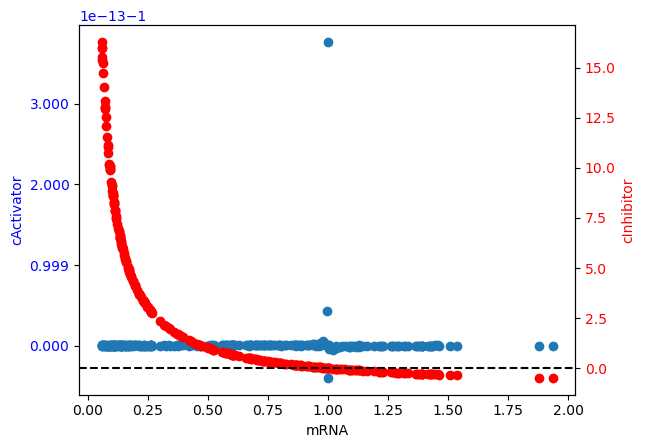

6.309573444801933e-06


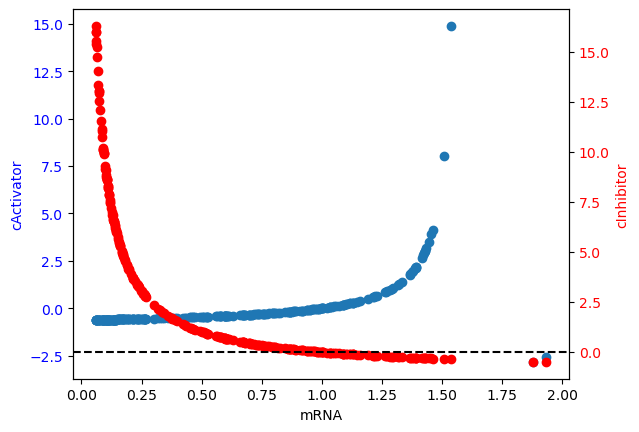

3.9810717055349725e-06


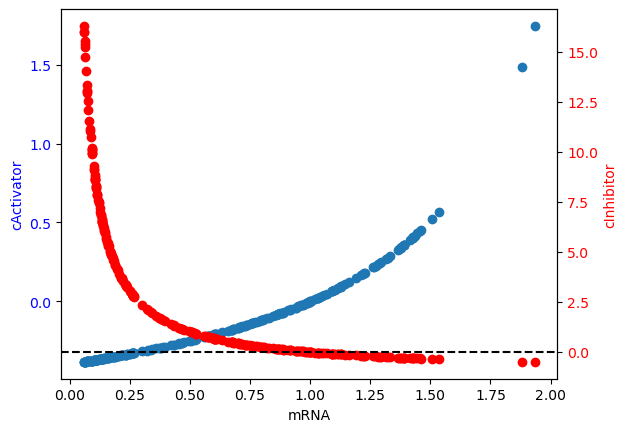

2.51188643150958e-06


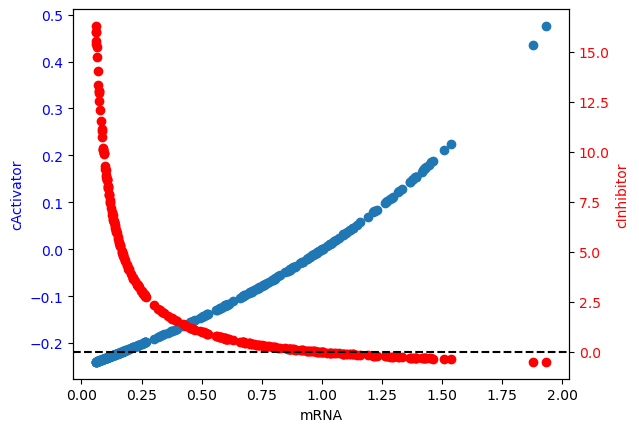

1.5848931924611137e-06


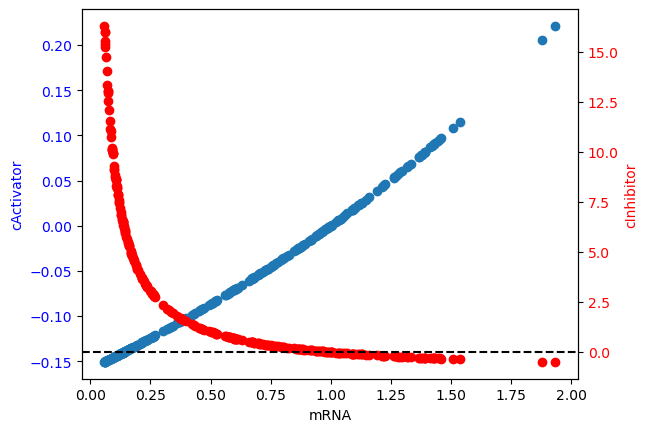

1.0000000000000002e-06


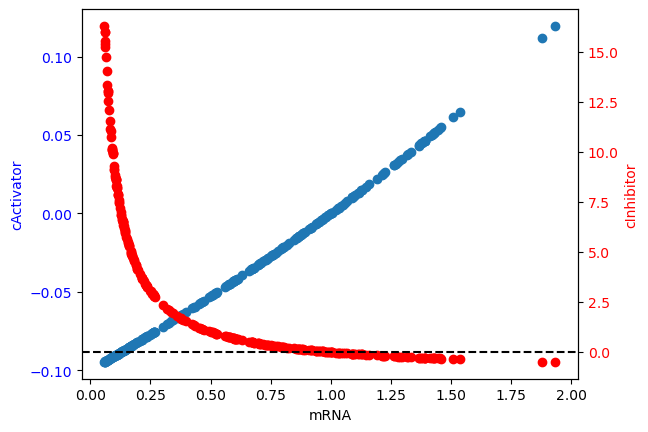

6.309573444801934e-07


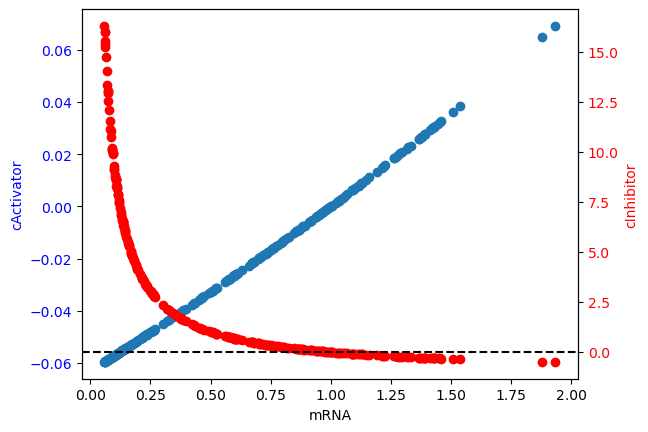

3.981071705534974e-07


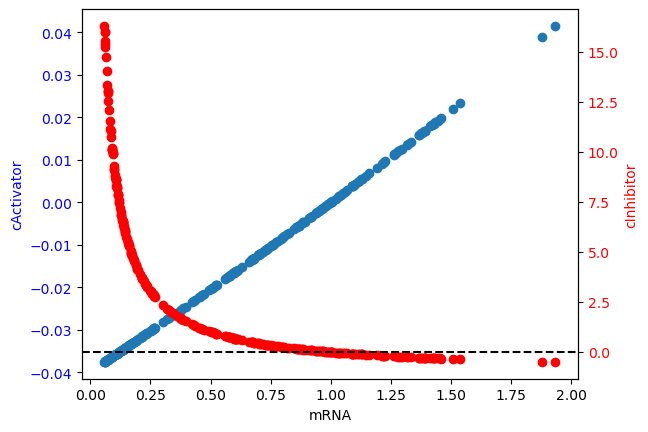

2.5118864315095796e-07


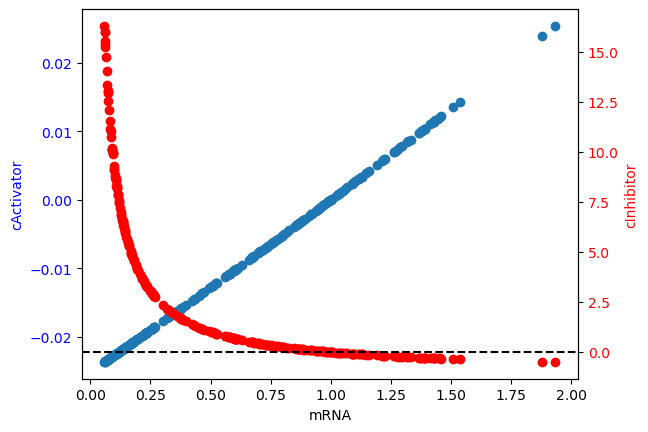

1.5848931924611136e-07


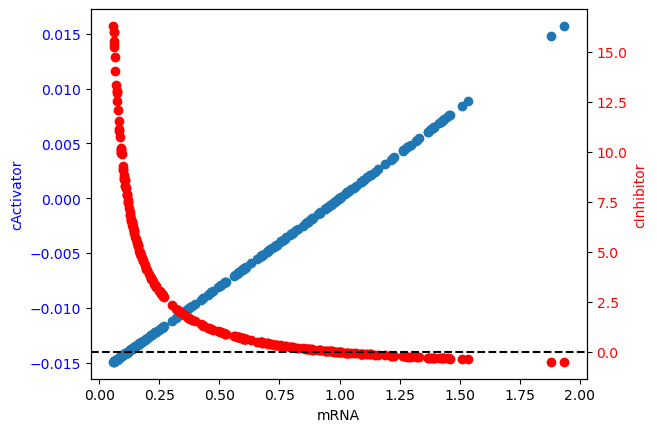

1.0000000000000001e-07


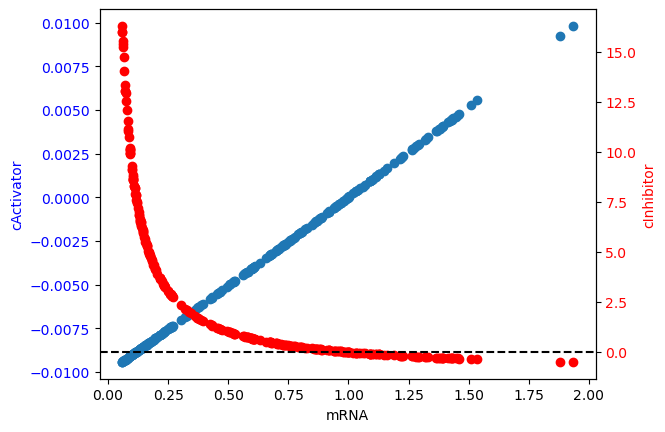

6.309573444801931e-08


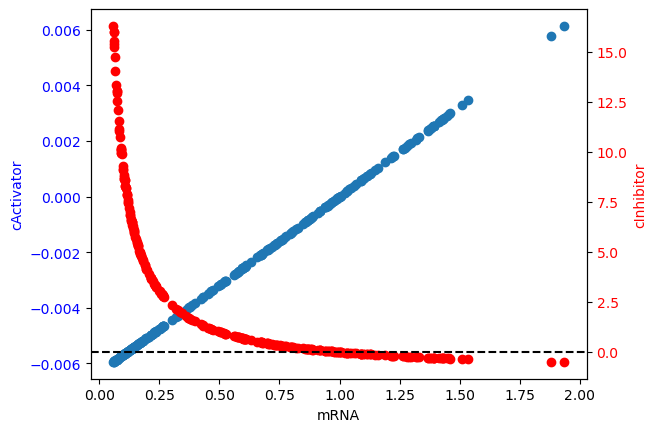

3.9810717055349736e-08


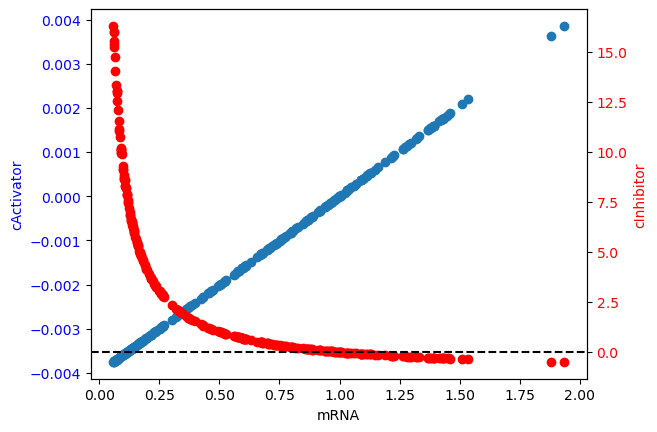

2.5118864315095798e-08


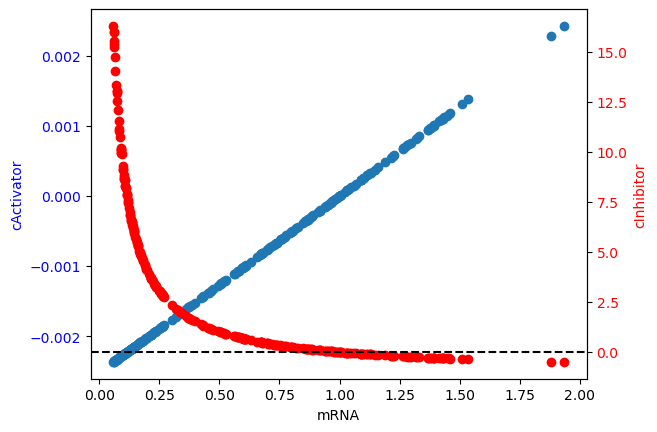

1.5848931924611143e-08


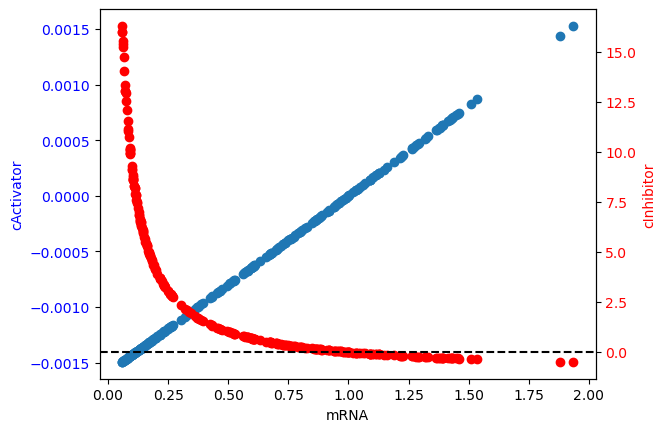

1e-08


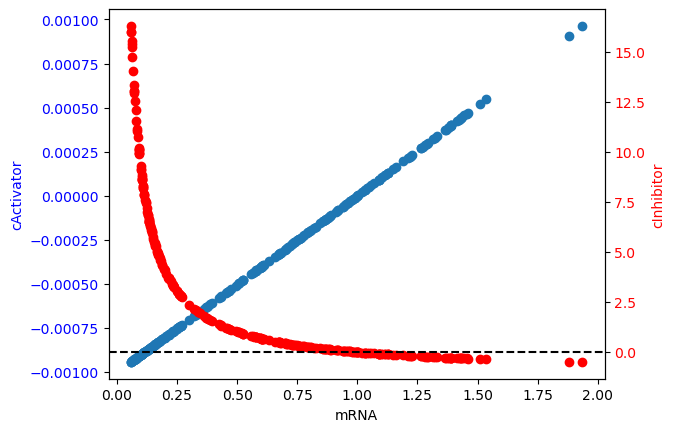

6.3095734448019305e-09


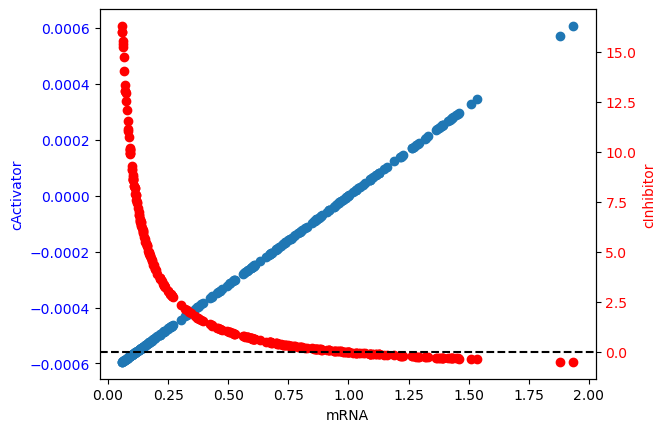

3.981071705534974e-09


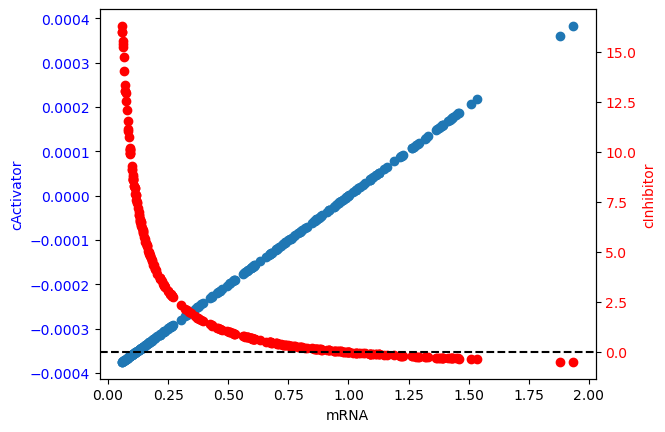

2.51188643150958e-09


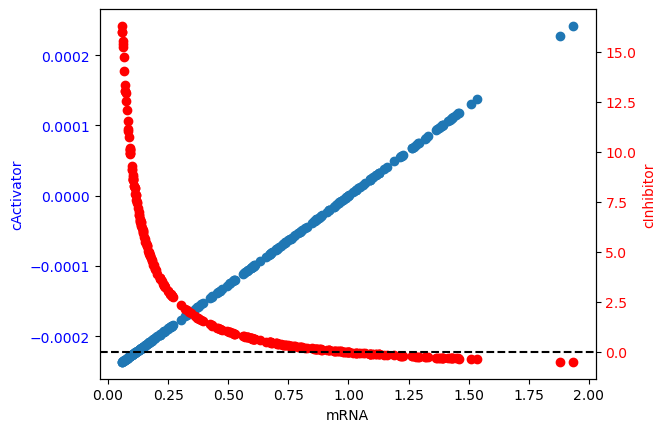

1.5848931924611142e-09


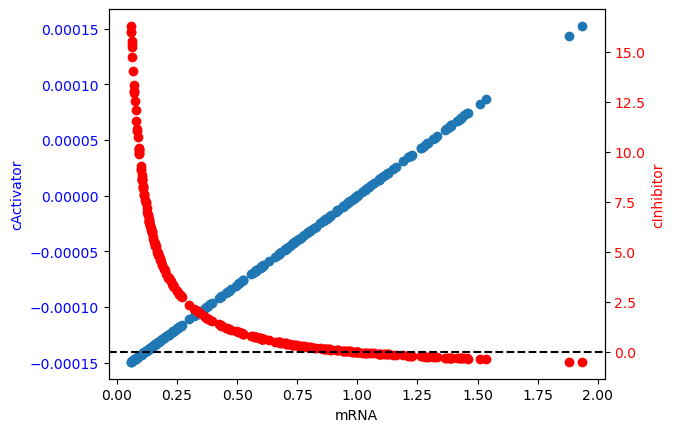

In [5]:
# Dan's suggestion - set cInhibitor to 0 to study cActivator and sweep values of KdRNAPCrp
# cInhibitor is not dependent on KdRNAPCrp so this doesn't really matter to it


# plot
for val in range(20):
    KdRNAPCrp_temp = KdRNAP*10**(-val/5)
    print(KdRNAPCrp_temp)
    fig, ax = plt.subplots()
    vals = mRNA_to_cActivator(ratios_df['actual_mRNA_ratio'], KdRNAPCrp = KdRNAPCrp_temp)
    ax.scatter(ratios_df['actual_mRNA_ratio'], vals)
    plt.xlabel('mRNA')
    ax.set_ylabel('cActivator', color = 'blue')
    ax.tick_params(axis = 'y', labelcolor = 'blue')
    #ax.set_ylim(-max(abs(vals)), max(abs(vals)))
    ax2 = ax.twinx()
    vals = mRNA_to_cInhibitor(ratios_df['actual_mRNA_ratio'])
    ax2.scatter(ratios_df['actual_mRNA_ratio'], vals, color = 'red')
    ax2.set_ylabel('cInhibitor', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    #ax2.set_ylim(-max(abs(vals)), max(abs(vals)))
    #plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), linestyle = '--', color = 'k')
    #plt.axvline(x = act_values_df.loc[controls]['mRNA'].mean(), linestyle = 'dotted', color = 'k')
    ax2.axhline(y = 0, linestyle = '--', color = 'k')
    plt.show()